https://www.kaggle.com/c/cassava-leaf-disease-classification/overview

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
root_path = "/content/drive/MyDrive/Data/Casava leaf Detection"
train_dir = "/content/drive/MyDrive/Data/Casava leaf Detection/train"
test_dir = "/content/drive/MyDrive/Data/Casava leaf Detection/test"
labels_dir =  os.path.join(root_path,"train.csv")
lr=1e-3
img_size=224

In [3]:
import pandas as pd
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import pandas as pd

labels = pd.read_csv(labels_dir)
print(labels)

             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [4]:
def label_image(img):
    mask=labels.loc[labels['image_id']==img]
    x=mask.label.iloc[0].astype(int)
    if x==0 : return [1,0,0,0,0]
    elif x==1: return [0,1,0,0,0]
    elif x==2: return [0,0,1,0,0]
    elif x==3: return [0,0,0,1,0]
    elif x==4: return [0,0,0,0,1]

In [5]:
def create_train_data():
    train_data=[]
    
    for img in tqdm(os.listdir(train_dir)):
        
        label=label_image(img)
        path=os.path.join(train_dir,img)
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_COLOR),(img_size,img_size))
        train_data.append([np.array(img),np.array(label)])
    shuffle(train_data)
    np.save(os.path.join(root_path,'train_data.npy'),train_data)
    return train_data

In [6]:
def process_test_data():
    test_data=[]
    
    for img in tqdm(os.listdir(test_dir)):
        img_label=img
        path=os.path.join(test_dir,img)
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_COLOR),(img_size,img_size))
        test_data.append([np.array(img),img_label])
    np.save(os.path.join(root_path,'test_data.npy'),test_data)
    return test_data

In [7]:
#train_data=create_train_data()
train_data=np.load(os.path.join(root_path,'train_data.npy'),allow_pickle=True)

In [8]:
train=train_data[:-1000]
test=train_data[-1000:]

In [9]:
X_train = np.array([i[0] for i in train]).reshape(-1,img_size,img_size,3)
y_train = np.array([i[1] for i in train])

X_test = np.array([i[0] for i in test]).reshape(-1,img_size,img_size,3)
y_test = np.array([i[1] for i in test])

Model-01

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,BatchNormalization,Dropout
import tensorflow.keras.layers.experimental.preprocessing as preprocessing

model=Sequential()
model.add(Conv2D(96,kernel_size=11,strides=(4,4),activation='relu',input_shape=(img_size,img_size,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(256,kernel_size=(5,5),strides=(1,1),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(384,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(384,kernel_size=(1,1),strides=(1,1),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,kernel_size=(1,1),strides=(1,1),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))

In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=15, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [12]:
if not os.path.exists(os.path.join(root_path,"model-01")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  #history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=128),epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  history=model.fit(X_train,y_train,batch_size=128,epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  model.save(os.path.join(root_path,"model-01"))
if os.path.exists(os.path.join(root_path,"model-01")):
  from tensorflow import keras
  model = keras.models.load_model(os.path.join(root_path,"model-01"))

In [13]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.6444084644317627

Best accuracy in evaluation: 0.6309999823570251



Model-02

In [14]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model

_input = Input((img_size,img_size,3)) 

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(5, activation="softmax")(dense2)

model  = Model(inputs=_input, outputs=output)

In [15]:
if not os.path.exists(os.path.join(root_path,"model-02")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  #history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=128),epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  history=model.fit(X_train,y_train,batch_size=128,epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  model.save(os.path.join(root_path,"model-02"))
if os.path.exists(os.path.join(root_path,"model-02")):
  from tensorflow import keras
  model = keras.models.load_model(os.path.join(root_path,"model-02"))


In [16]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.738932192325592

Best accuracy in evaluation: 0.6819999814033508



Model-03

In [17]:
import tensorflow_hub as hub
import tensorflow as tf

feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_size,img_size,3))
feature_extractor_layer.tranable = False

In [18]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5,activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
import pickle
if not os.path.exists(os.path.join(root_path,"model-03")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  #history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=128),epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  history=model.fit(X_train,y_train,batch_size=128,epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  model.save(os.path.join(root_path,"model-03"))
  with open(os.path.join(root_path,"model-03-history"), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
if os.path.exists(os.path.join(root_path,"model-03")):
  from tensorflow import keras
  model = keras.models.load_model(os.path.join(root_path,"model-03"))


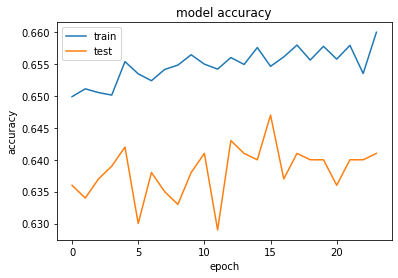

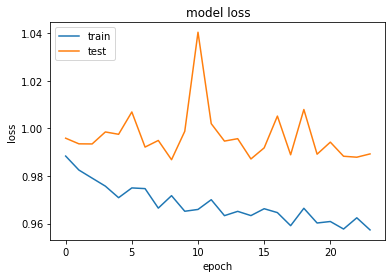

In [21]:
history = pickle.load(open(os.path.join(root_path,"model-03-history"), "rb"))
import matplotlib.pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.6617149710655212

Best accuracy in evaluation: 0.6330000162124634



**Model**-**04**
ResNET 50

In [23]:
import tensorflow_hub as hub
import tensorflow as tf

feature_extractor = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_size,img_size,3))
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5,activation='softmax')
])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
import pickle
if not os.path.exists(os.path.join(root_path,"model-04")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  #history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=128),epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  history=model.fit(X_train,y_train,batch_size=128,epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  model.save(os.path.join(root_path,"model-04"))
  with open(os.path.join(root_path,"model-04-history"), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
if os.path.exists(os.path.join(root_path,"model-04")):
  from tensorflow import keras
  model = keras.models.load_model(os.path.join(root_path,"model-04"))


In [26]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.6164631843566895

Best accuracy in evaluation: 0.574999988079071



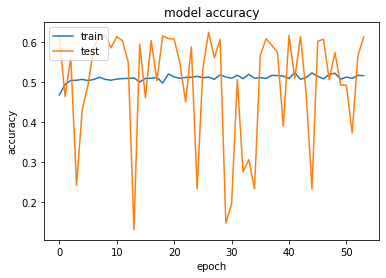

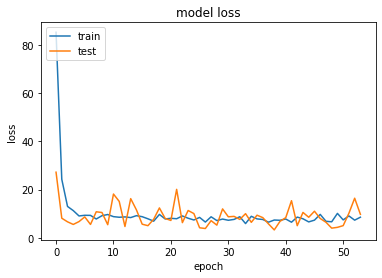

In [27]:
history = pickle.load(open(os.path.join(root_path,"model-04-history"), "rb"))
import matplotlib.pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model-05 Inception ResNET v2


In [28]:
import tensorflow_hub as hub
import tensorflow as tf

feature_extractor = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_size,img_size,3))
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5,activation='softmax')
])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1001)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5010      
Total params: 55,880,283
Trainable params: 5,010
Non-trainable params: 55,875,273
_________________________________________________________________


In [30]:
import pickle
if not os.path.exists(os.path.join(root_path,"model-05")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  #history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=128),epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  history=model.fit(X_train,y_train,batch_size=128,epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  model.save(os.path.join(root_path,"model-05"))
  with open(os.path.join(root_path,"model-05-history"), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
if os.path.exists(os.path.join(root_path,"model-05")):
  from tensorflow import keras
  model = keras.models.load_model(os.path.join(root_path,"model-05"))


In [31]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.5971956849098206

Best accuracy in evaluation: 0.5789999961853027



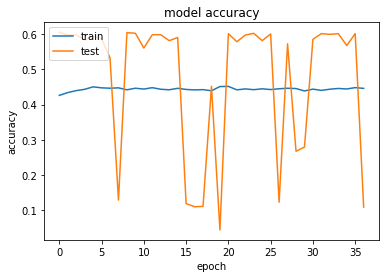

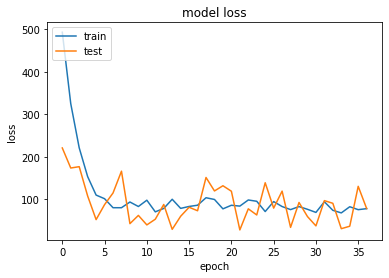

In [32]:
history = pickle.load(open(os.path.join(root_path,"model-05-history"), "rb"))
import matplotlib.pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model-06

In [33]:
import tensorflow_hub as hub
import tensorflow as tf

feature_extractor = "https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor,input_shape=(img_size,img_size,3))
feature_extractor_layer.tranable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5,activation='softmax')
])

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 6)                 4234118   
_________________________________________________________________
dropout_5 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 35        
Total params: 4,234,153
Trainable params: 35
Non-trainable params: 4,234,118
_________________________________________________________________


In [35]:
import pickle
if not os.path.exists(os.path.join(root_path,"model-06")):
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  #history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=128),epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  history=model.fit(X_train,y_train,batch_size=128,epochs=100,callbacks=[early_stopping],validation_data=(X_test,y_test))
  model.save(os.path.join(root_path,"model-06"))
  with open(os.path.join(root_path,"model-06-history"), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
if os.path.exists(os.path.join(root_path,"model-06")):
  from tensorflow import keras
  model = keras.models.load_model(os.path.join(root_path,"model-06"))


Epoch 1/100
160/160 [==============================] - 21s 90ms/step - loss: 1.8282 - accuracy: 0.2488 - val_loss: 1.5872 - val_accuracy: 0.1100
Epoch 2/100
160/160 [==============================] - 13s 79ms/step - loss: 1.5598 - accuracy: 0.2589 - val_loss: 1.4029 - val_accuracy: 0.6010
Epoch 3/100
160/160 [==============================] - 13s 79ms/step - loss: 1.3846 - accuracy: 0.5509 - val_loss: 1.2950 - val_accuracy: 0.6010
Epoch 4/100
160/160 [==============================] - 13s 78ms/step - loss: 1.2865 - accuracy: 0.6132 - val_loss: 1.2415 - val_accuracy: 0.6010
Epoch 5/100
160/160 [==============================] - 13s 79ms/step - loss: 1.2348 - accuracy: 0.6158 - val_loss: 1.2184 - val_accuracy: 0.6010
Epoch 6/100
160/160 [==============================] - 13s 79ms/step - loss: 1.2186 - accuracy: 0.6119 - val_loss: 1.2085 - val_accuracy: 0.6010
Epoch 7/100
160/160 [==============================] - 13s 79ms/step - loss: 1.2055 - accuracy: 0.6149 - val_loss: 1.2043 - val_ac

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Data/Casava leaf Detection/model-06/assets


In [36]:
_, eval_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"In train evaluation: {eval_acc}\n")
_, eval_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Best accuracy in evaluation: {eval_acc}\n")

In train evaluation: 0.6156297326087952

Best accuracy in evaluation: 0.6010000109672546



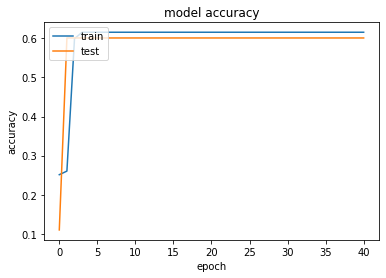

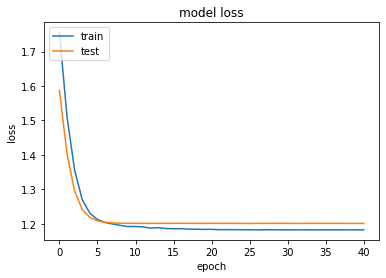

In [37]:
history = pickle.load(open(os.path.join(root_path,"model-06-history"), "rb"))
import matplotlib.pyplot as plt

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()